In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

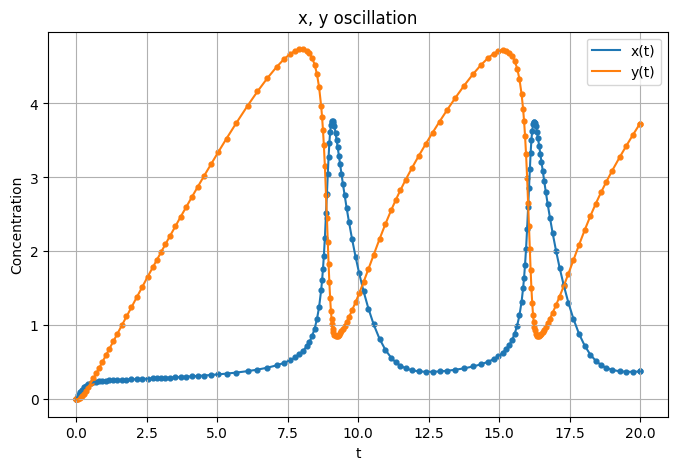

In [7]:
# Q1 Alternative Method
a, b = 1.0, 3.0
t0, tf = 0.0, 20.0
y0 = np.array([0.0, 0.0])  # x(0), y(0)

def brusselator(t, y):
    x, yv = y
    dx = 1 - (b + 1)*x + a*x*x*yv
    dy = b*x - a*x*x*yv
    return [dx, dy]


sol = solve_ivp(
    brusselator,
    (t0, tf),
    y0,
    method="DOP853",
    rtol=1e-10,
    atol=1e-12,          
    dense_output=False   
)

t = sol.t
x, y = sol.y

plt.figure(figsize=(8, 5))
plt.plot(t, x, label="x(t)")
plt.plot(t, y, label="y(t)")
plt.scatter(t, x, s=12)
plt.scatter(t, y, s=12)
plt.xlabel("t")
plt.ylabel("Concentration")
plt.title("x, y oscillation")
plt.grid(True)
plt.legend()
plt.savefig("Q1_answer_alternative")
plt.show()

/var/folders/j1/1nbcfcr10xb950yxrfc_06z40000gn/T/ipykernel_11776/3462262322.py:5: RuntimeWarning: overflow encountered in scalar multiply
  dx = 1.0 - (b + 1.0) * x + a * x * x * yv
/var/folders/j1/1nbcfcr10xb950yxrfc_06z40000gn/T/ipykernel_11776/3462262322.py:6: RuntimeWarning: overflow encountered in scalar multiply
  dy = b * x - a * x * x * yv
/var/folders/j1/1nbcfcr10xb950yxrfc_06z40000gn/T/ipykernel_11776/3462262322.py:18: RuntimeWarning: invalid value encountered in add
  return 0.5 * (y0 + y1 + dt * f(t + h, y1))


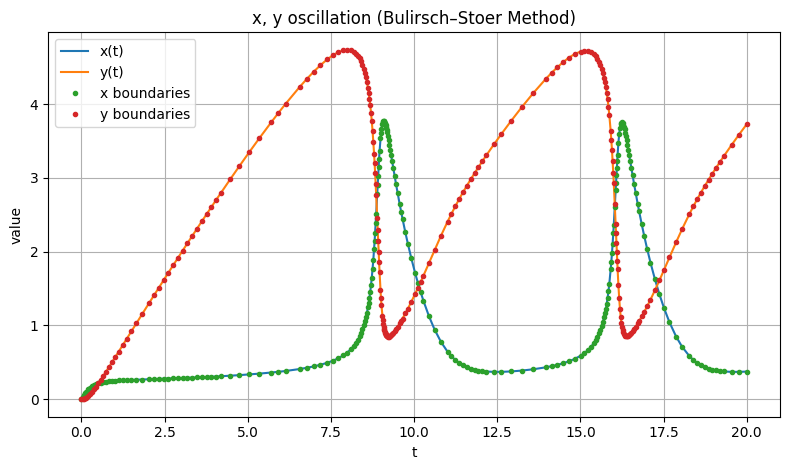

Accepted steps: 222, Rejected attempts: 139


In [10]:
# Q1 adaptive Bulirsch–Stoer Method

def f(t, y, a=1.0, b=3.0):
    x, yv = y
    dx = 1.0 - (b + 1.0) * x + a * x * x * yv
    dy = b * x - a * x * x * yv
    return np.array([dx, dy], dtype=float)

def modified_midpoint(f, t, y, h, n):
    dt = h / n
    y0 = y.copy()
    y1 = y0 + dt * f(t, y0)
    t_curr = t + dt
    for _ in range(2, n + 1):
        y2 = y0 + 2.0 * dt * f(t_curr, y1)
        y0, y1 = y1, y2
        t_curr += dt
    return 0.5 * (y0 + y1 + dt * f(t + h, y1))


def bulirsch_stoer_attempt(f, t, y, h, delta, n_max=8):
    ns = [n for n in range(2, n_max + 1, 2)] 
    table = []
    y_prev = None
    tol_vec = np.full_like(y, delta * abs(h))

    for i, n in enumerate(ns):
        y_mm = modified_midpoint(f, t, y, h, n)
        table.append([y_mm])

        for k in range(1, i + 1):
            ratio = (ns[i] / ns[i - k]) ** 2
            yk = table[i][k - 1] + (table[i][k - 1] - table[i - 1][k - 1]) / (ratio - 1.0)
            table[i].append(yk)

        y_extr = table[i][-1]
        if y_prev is not None:
            err = np.abs(y_extr - y_prev)
            if np.all(err <= tol_vec):
                return True, y_extr, err, np.max(err / tol_vec), n
        y_prev = y_extr

    err = np.abs(y_prev - table[-1][-2]) if len(ns) > 1 else np.abs(table[0][0] - y)
    return False, y_prev, err, np.max(err / tol_vec), ns[-1]


def integrate_brusselator(t0=0.0, t1=20.0, x0=0.0, y0=0.0, a=1.0, b=3.0,
                          H=20.0, delta=1e-8, n_max=8,
                          h_min=1e-12, h_max=None):
   
    if h_max is None:
        h_max = H

    t = t0
    y = np.array([x0, y0], dtype=float)
    h = np.sign(t1 - t0) * H

    ts, xs, ys = [t], [y[0]], [y[1]]
    boundaries = [t]
    accepted = rejected = 0

    while (t < t1 and h > 0) or (t > t1 and h < 0):
        if (t + h > t1 and h > 0) or (t + h < t1 and h < 0):
            h = t1 - t

        ok, y_new, err_vec, r, used_n = bulirsch_stoer_attempt(
            lambda tt, yy: f(tt, yy, a, b), t, y, h, delta, n_max=n_max
        )

        if ok:
            t += h
            y = y_new
            ts.append(t); xs.append(y[0]); ys.append(y[1])
            boundaries.append(t)
            accepted += 1

            if r < 0.1 and abs(h) < abs(h_max):
                h = np.sign(h) * min(abs(2.0 * h), abs(h_max))
            else:
                factor = 0.9 * (1.0 / max(r, 1e-16)) ** 0.25
                factor = min(2.0, max(0.5, factor))
                h = np.sign(h) * min(abs(h_max), max(abs(h_min), abs(h) * factor))
        else:
            h *= 0.5
            rejected += 1
            if abs(h) < h_min:
                raise RuntimeError("Step size underflow. Integration stalled.")

    return {
        "t": np.array(ts),
        "x": np.array(xs),
        "y": np.array(ys),
        "boundaries": np.array(boundaries),
        "accepted": accepted,
        "rejected": rejected,
    }

if __name__ == "__main__":
    sol = integrate_brusselator(a=1.0, b=3.0, t0=0.0, t1=20.0,
                                x0=0.0, y0=0.0, H=20.0,
                                delta=1e-8, n_max=8, h_max=40.0)

    fig, ax = plt.subplots(figsize=(8, 4.8))
    ax.plot(sol["t"], sol["x"], label="x(t)")
    ax.plot(sol["t"], sol["y"], label="y(t)")
    ax.plot(sol["boundaries"],
            np.interp(sol["boundaries"], sol["t"], sol["x"]), ".", label="x boundaries")
    ax.plot(sol["boundaries"],
            np.interp(sol["boundaries"], sol["t"], sol["y"]), ".", label="y boundaries")
    ax.set_xlabel("t"); ax.set_ylabel("value"); ax.legend()
    ax.set_title("x, y oscillation (Bulirsch–Stoer Method)")
    plt.tight_layout()
    plt.grid(True)
    plt.savefig('Q1_answer')
    plt.show()

    print(f"Accepted steps: {sol['accepted']}, Rejected attempts: {sol['rejected']}")

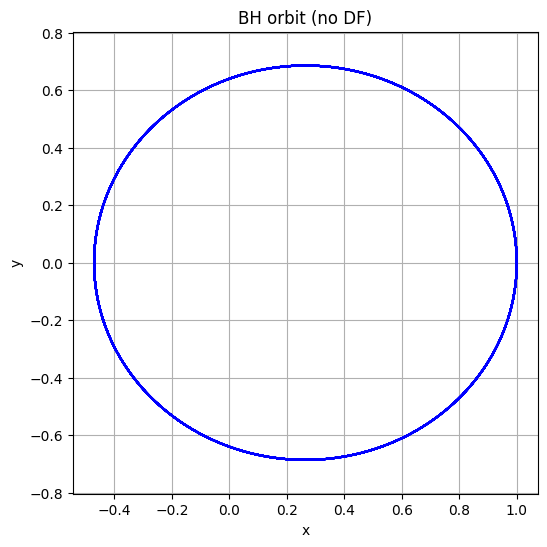

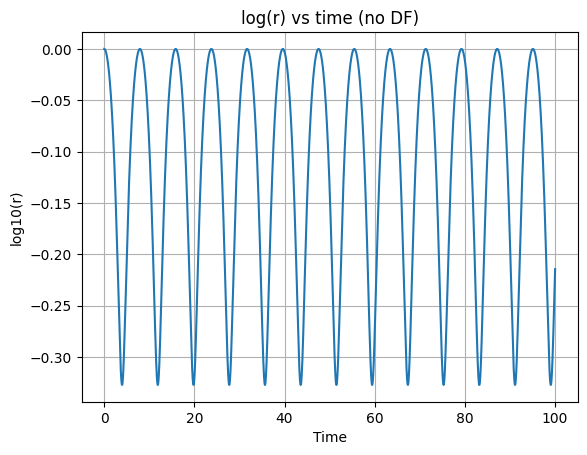

In [16]:
#Q2 a)

# Constants and parameters
G = 1.0
M = 1.0
r_s = 1e-7     # Schwarzschild radius
A = 1.0        # DF parameter
B = 1.0        # DF parameter
use_DF = False  # toggle dynamical friction (part a: False, part b: True)

# Adaptive RK45 parameters
rtol = 1e-8
atol = 1e-8
h0 = 1e-3
h_max = 1e-2
safety = 0.9

# initial conditions
r0 = np.array([1.0, 0.0])
v_circ = math.sqrt(G*M/(4*np.linalg.norm(r0)))
v0 = np.array([0.0, 0.8*v_circ])  # 80% of circular velocity
y0 = np.hstack([r0, v0])
t0, t1 = 0.0, 100.0   # integrate long enough to see decay

# Equation of motion
def acceleration(r, v):
    rnorm = np.linalg.norm(r)
    a_grav = -G*M * r / (4*rnorm**3)
    if use_DF:
        vnorm = np.linalg.norm(v)
        a_df = -A * v / (vnorm**3 + B)
    else:
        a_df = np.zeros_like(r)
    return a_grav + a_df

def f(t, y):
    r = y[:2]
    v = y[2:]
    a = acceleration(r, v)
    return np.hstack([v, a])

# Dormand–Prince RK45 integrator
def rk45_step(fun, t, y, h):
    c2,c3,c4,c5,c6 = 1/5, 3/10, 4/5, 8/9, 1.0
    a21 = 1/5
    a31,a32 = 3/40, 9/40
    a41,a42,a43 = 44/45, -56/15, 32/9
    a51,a52,a53,a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    a61,a62,a63,a64,a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    a71,a72,a73,a74,a75,a76 = 35/384, 0.0, 500/1113, 125/192, -2187/6784, 11/84
    b1h,b3h,b4h,b5h,b6h,b7h = 5179/57600, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

    k1 = fun(t, y)
    k2 = fun(t + c2*h, y + h*a21*k1)
    k3 = fun(t + c3*h, y + h*(a31*k1 + a32*k2))
    k4 = fun(t + c4*h, y + h*(a41*k1 + a42*k2 + a43*k3))
    k5 = fun(t + c5*h, y + h*(a51*k1 + a52*k2 + a53*k3 + a54*k4))
    k6 = fun(t + c6*h, y + h*(a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5))

    y5 = y + h*(a71*k1 + a72*k2 + a73*k3 + a74*k4 + a75*k5 + a76*k6)
    y4 = y + h*(b1h*k1 + b3h*k3 + b4h*k4 + b5h*k5 + b6h*k6 + b7h*fun(t + h, y5))

    err = np.linalg.norm(y5 - y4)
    return y5, err

def integrate_adaptive(fun, t0, y0, t1, h0):
    t = t0
    y = y0.copy()
    h = h0
    times, states = [t], [y.copy()]
    while t < t1:
        if np.linalg.norm(y[:2]) < r_s:
            print(f"Reached Schwarzschild radius at t={t:.4e}")
            break
        if t + h > t1:
            h = t1 - t
        y_try, err = rk45_step(fun, t, y, h)
        tol = atol + rtol*np.linalg.norm(y_try)
        if err < tol:
            t += h
            y = y_try
            times.append(t)
            states.append(y.copy())
        # adapt step
        h *= min(2, max(0.2, safety*(tol/err)**0.25))
        h = min(h, h_max)
    return np.array(times), np.array(states)

# Run the simulation
times, states = integrate_adaptive(f, t0, y0, t1, h0)
r = states[:, :2]
v = states[:, 2:]
r_norm = np.linalg.norm(r, axis=1)

# -----------------------
# Plots
# -----------------------
plt.figure(figsize=(6,6))
plt.plot(r[:,0], r[:,1], '-b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("BH orbit" + (" with DF" if use_DF else " (no DF)"))
plt.axis("equal")
plt.grid(True)
plt.savefig("Q2_a_orbit")

plt.figure()
plt.plot(times, np.log10(r_norm))
plt.xlabel("Time")
plt.ylabel("log10(r)")
plt.title("log(r) vs time" + (" with DF" if use_DF else " (no DF)"))
plt.grid(True)
plt.savefig("Q2_a_accuracy")
plt.show()

Reached Schwarzschild radius at t=1.0763e+01


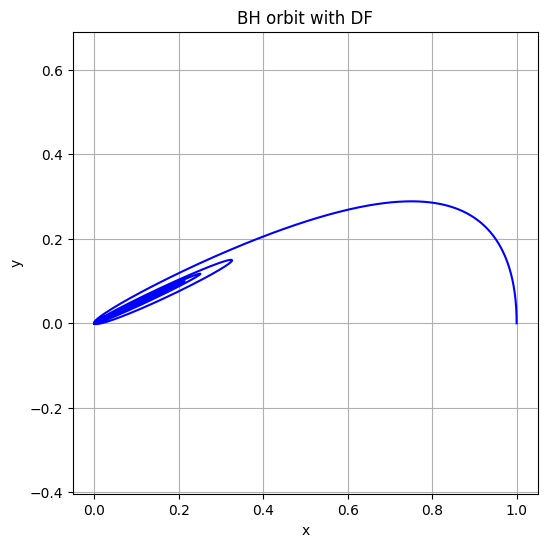

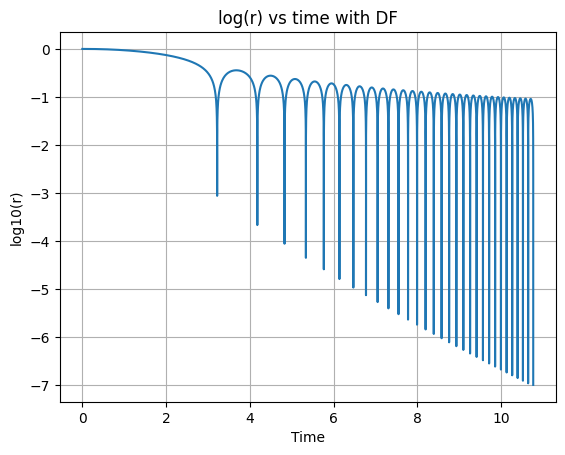

In [17]:
#Q2 b)

# Constants and parameters
G = 1.0
M = 1.0
r_s = 1e-7     # Schwarzschild radius
A = 1.0        # DF parameter
B = 1.0        # DF parameter
use_DF = True  # toggle dynamical friction (part a: False, part b: True)

# Adaptive RK45 parameters
rtol = 1e-8
atol = 1e-8
h0 = 1e-3
h_max = 1e-2
safety = 0.9

# initial conditions
r0 = np.array([1.0, 0.0])
v_circ = math.sqrt(G*M/(4*np.linalg.norm(r0)))
v0 = np.array([0.0, 0.8*v_circ])  # 80% of circular velocity
y0 = np.hstack([r0, v0])
t0, t1 = 0.0, 100.0   # integrate long enough to see decay

# Equation of motion
def acceleration(r, v):
    rnorm = np.linalg.norm(r)
    a_grav = -G*M * r / (4*rnorm**3)
    if use_DF:
        vnorm = np.linalg.norm(v)
        a_df = -A * v / (vnorm**3 + B)
    else:
        a_df = np.zeros_like(r)
    return a_grav + a_df

def f(t, y):
    r = y[:2]
    v = y[2:]
    a = acceleration(r, v)
    return np.hstack([v, a])

# Dormand–Prince RK45 integrator
def rk45_step(fun, t, y, h):
    c2,c3,c4,c5,c6 = 1/5, 3/10, 4/5, 8/9, 1.0
    a21 = 1/5
    a31,a32 = 3/40, 9/40
    a41,a42,a43 = 44/45, -56/15, 32/9
    a51,a52,a53,a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    a61,a62,a63,a64,a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    a71,a72,a73,a74,a75,a76 = 35/384, 0.0, 500/1113, 125/192, -2187/6784, 11/84
    b1h,b3h,b4h,b5h,b6h,b7h = 5179/57600, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

    k1 = fun(t, y)
    k2 = fun(t + c2*h, y + h*a21*k1)
    k3 = fun(t + c3*h, y + h*(a31*k1 + a32*k2))
    k4 = fun(t + c4*h, y + h*(a41*k1 + a42*k2 + a43*k3))
    k5 = fun(t + c5*h, y + h*(a51*k1 + a52*k2 + a53*k3 + a54*k4))
    k6 = fun(t + c6*h, y + h*(a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5))

    y5 = y + h*(a71*k1 + a72*k2 + a73*k3 + a74*k4 + a75*k5 + a76*k6)
    y4 = y + h*(b1h*k1 + b3h*k3 + b4h*k4 + b5h*k5 + b6h*k6 + b7h*fun(t + h, y5))

    err = np.linalg.norm(y5 - y4)
    return y5, err

def integrate_adaptive(fun, t0, y0, t1, h0):
    t = t0
    y = y0.copy()
    h = h0
    times, states = [t], [y.copy()]
    while t < t1:
        if np.linalg.norm(y[:2]) < r_s:
            print(f"Reached Schwarzschild radius at t={t:.4e}")
            break
        if t + h > t1:
            h = t1 - t
        y_try, err = rk45_step(fun, t, y, h)
        tol = atol + rtol*np.linalg.norm(y_try)
        if err < tol:
            t += h
            y = y_try
            times.append(t)
            states.append(y.copy())
        # adapt step
        h *= min(2, max(0.2, safety*(tol/err)**0.25))
        h = min(h, h_max)
    return np.array(times), np.array(states)

# Run the simulation
times, states = integrate_adaptive(f, t0, y0, t1, h0)
r = states[:, :2]
v = states[:, 2:]
r_norm = np.linalg.norm(r, axis=1)

# -----------------------
# Plots
# -----------------------
plt.figure(figsize=(6,6))
plt.plot(r[:,0], r[:,1], '-b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("BH orbit" + (" with DF" if use_DF else " (no DF)"))
plt.axis("equal")
plt.grid(True)
plt.savefig("Q2_b_orbit")

plt.figure()
plt.plot(times, np.log10(r_norm))
plt.xlabel("Time")
plt.ylabel("log10(r)")
plt.title("log(r) vs time" + (" with DF" if use_DF else " (no DF)"))
plt.grid(True)
plt.savefig("Q2_b_accuracy")
plt.show()

Reached Schwarzschild radius at t=1.0739085471752605Myr


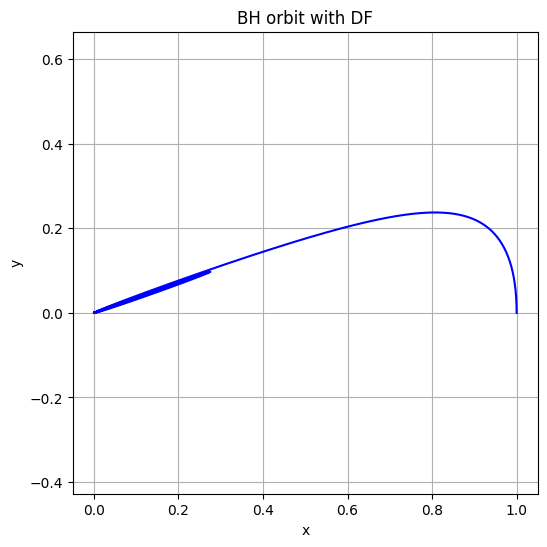

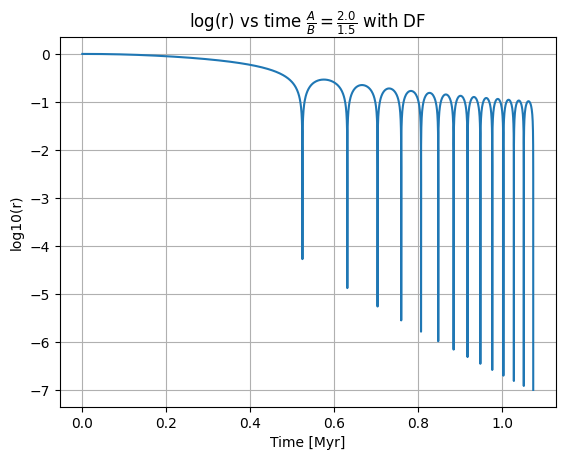

In [29]:
#Q2 c)

# Constants and parameters
G = 1.0
M = 1.0
r_s = 1e-7     # Schwarzschild radius
A = 2.0        # DF parameter
B = 1.5        # DF parameter
use_DF = True  # toggle dynamical friction (part a: False, part b: True)

# Adaptive RK45 parameters
rtol = 1e-8
atol = 1e-8
h0 = 1e-3
h_max = 1e-2
safety = 0.9

# initial conditions
r0 = np.array([1.0, 0.0])
v_circ = math.sqrt(G*M/(4*np.linalg.norm(r0)))
v0 = np.array([0.0, 0.8*v_circ])  # 80% of circular velocity
y0 = np.hstack([r0, v0])
t0, t1 = 0.0, 100.0   # integrate long enough to see decay

# Equation of motion
def acceleration(r, v):
    rnorm = np.linalg.norm(r)
    a_grav = -G*M * r / (4*rnorm**3)
    if use_DF:
        vnorm = np.linalg.norm(v)
        a_df = -A * v / (vnorm**3 + B)
    else:
        a_df = np.zeros_like(r)
    return a_grav + a_df

def f(t, y):
    r = y[:2]
    v = y[2:]
    a = acceleration(r, v)
    return np.hstack([v, a])

# Dormand–Prince RK45 integrator
def rk45_step(fun, t, y, h):
    c2,c3,c4,c5,c6 = 1/5, 3/10, 4/5, 8/9, 1.0
    a21 = 1/5
    a31,a32 = 3/40, 9/40
    a41,a42,a43 = 44/45, -56/15, 32/9
    a51,a52,a53,a54 = 19372/6561, -25360/2187, 64448/6561, -212/729
    a61,a62,a63,a64,a65 = 9017/3168, -355/33, 46732/5247, 49/176, -5103/18656
    a71,a72,a73,a74,a75,a76 = 35/384, 0.0, 500/1113, 125/192, -2187/6784, 11/84
    b1h,b3h,b4h,b5h,b6h,b7h = 5179/57600, 7571/16695, 393/640, -92097/339200, 187/2100, 1/40

    k1 = fun(t, y)
    k2 = fun(t + c2*h, y + h*a21*k1)
    k3 = fun(t + c3*h, y + h*(a31*k1 + a32*k2))
    k4 = fun(t + c4*h, y + h*(a41*k1 + a42*k2 + a43*k3))
    k5 = fun(t + c5*h, y + h*(a51*k1 + a52*k2 + a53*k3 + a54*k4))
    k6 = fun(t + c6*h, y + h*(a61*k1 + a62*k2 + a63*k3 + a64*k4 + a65*k5))

    y5 = y + h*(a71*k1 + a72*k2 + a73*k3 + a74*k4 + a75*k5 + a76*k6)
    y4 = y + h*(b1h*k1 + b3h*k3 + b4h*k4 + b5h*k5 + b6h*k6 + b7h*fun(t + h, y5))

    err = np.linalg.norm(y5 - y4)
    return y5, err

def integrate_adaptive(fun, t0, y0, t1, h0):
    t = t0
    y = y0.copy()
    h = h0
    times, states = [t], [y.copy()]
    while t < t1:
        if np.linalg.norm(y[:2]) < r_s:
            t_Myr = t*0.152
            print(f"Reached Schwarzschild radius at t={t_Myr}Myr")
            break
        if t + h > t1:
            h = t1 - t
        y_try, err = rk45_step(fun, t, y, h)
        tol = atol + rtol*np.linalg.norm(y_try)
        if err < tol:
            t += h
            y = y_try
            times.append(t)
            states.append(y.copy())
        # adapt step
        h *= min(2, max(0.2, safety*(tol/err)**0.25))
        h = min(h, h_max)
    return np.array(times), np.array(states)

# Run the simulation
times, states = integrate_adaptive(f, t0, y0, t1, h0)
r = states[:, :2]
v = states[:, 2:]
r_norm = np.linalg.norm(r, axis=1)

# -----------------------
# Plots
# -----------------------
plt.figure(figsize=(6,6))
plt.plot(r[:,0], r[:,1], '-b')
plt.xlabel("x")
plt.ylabel("y")
plt.title("BH orbit" + (" with DF" if use_DF else " (no DF)"))
plt.axis("equal")
plt.grid(True)
plt.savefig("Q2_c_orbit")

plt.figure()
plt.plot(times*0.152, np.log10(r_norm))
plt.xlabel(r"Time [Myr]")
plt.ylabel("log10(r)")
plt.title(r"log(r) vs time $\frac{A}{B} = \frac{2.0}{1.5}$" + (" with DF" if use_DF else " (no DF)"))
plt.grid(True)
plt.savefig("Q2_c_accuracy")
plt.show()